In [1]:
import matplotlib.pyplot as plt

import numpy as np
from AnastrisTNG import TNGsimulation

In [2]:
from gal3d.analyzer import Gal3DAnalyzer


                                         .--,-``-.                    
    ,----..                    ,--,     /   /     '.       ,---,      
   /   /   \                 ,--.'|    / ../        ;    .'  .' `\    
  |   :     :                |  | :    \ ``\  .`-    ' ,---.'     \   
  .   |  ;. /                :  : '     \___\/   \   : |   |  .`\  |  
  .   ; /--`      ,--.--.    |  ' |          \   :   | :   : |  '  |  
  ;   | ;  __    /       \   '  | |          /  /   /  |   ' '  ;  :  
  |   : |.' .'  .--.  .-. |  |  | :          \  \   \  '   | ;  .  |  
  .   | '_.' :   \__\/: . .  '  : |__    ___ /   :   | |   | :  |  '  
  '   ; : \  |   ," .--.; |  |  | '.'|  /   /\   /   : '   : | /  ;   
  '   | '/  .'  /  /  ,.  |  ;  :    ; / ,,/  ',-    . |   | '` ,/    
  |   :    /   ;  :   .'   \ |  ,   /  \ ''\        ;  ;   :  .'      
   \   \ .'    |  ,     .-./  ---`-'    \   \     .'   |   ,.'        
    `---`       `--`---'                 `--`-,,-'     '---'          

    

In [3]:
from gal3d.point import Particles
from gal3d.field import SphField

from gal3d.shape import Structure3D
from gal3d.optimization.optimizer import Optimizer
from gal3d.visualization.data_model_residual import show_image_model_residual
from gal3d.visualization.model_projector import ModelProjector
from gal3d.characterization.characterizer import Characterizer

[2025-04-23 17:15:02.920] < gal3d.visualization.model_projector >
  >>>  | INFO | Find ModelProjectorPlugin: ProjectorLineIntegration and load successfully
[2025-04-23 17:15:02.921] < gal3d.visualization.model_projector >
  >>>  | INFO | Find ModelProjectorPlugin: ProjectorSphGrid and load successfully


In [4]:
path = '/home/yxi/Simulation/TNG50-1/TNG50-1/output'
snap =99
snapshot = TNGsimulation.Snapshot(path,snap)

In [5]:
ID = 229934         # 467415   516760 229934  392276 229935  282780
sub = snapshot.load_particle(ID,order='star')
sub.physical_units()
coor_trans = sub.face_on(alignwith='star',rmax=8)

Num_rays = min(1024,int(len(sub.s)/100))
Num_rays = max(Num_rays,int(len(sub.s)/10000))

On the edge of the box, move to center


In [6]:
pos = sub.s['pos'].view(np.ndarray)
mass=sub.s['mass'].view(np.ndarray)
softening_length = float(sub['eps'].in_units('kpc'))
Volume = (4*np.pi*softening_length**3)
outer_value = np.mean(mass)/Volume

In [7]:
particle = Particles(pos = pos,mass=mass,estimator_kwargs={"k_nearest":32,"r_cut": 10*softening_length})

[2025-04-23 17:15:23.598] < gal3d.particle.density_estimator >
  >>>  | INFO | Find DensityEstimatorPlugin: DensityEstimatorKNN and load successfully
[2025-04-23 17:15:23.599] < gal3d.particle.density_estimator >
  >>>  | INFO | Successfully loaded density estimator plugins
[2025-04-23 17:15:23.599] < gal3d.particle.density_estimator.DensityEstimatorKNN >
  >>>  | INFO | cpu nums: 16
[2025-04-23 17:15:23.600] < gal3d.particle.density_estimator.DensityEstimatorKNN >
  >>>  | INFO | Build KDtree with options {'leafsize': 32, 'compact_nodes': True, 'copy_data': False, 'balanced_tree': True, 'boxsize': None}


In [8]:
field = SphField(particle,num_ray=Num_rays,ray_method='fibonacci'
    ).build_field_boundary(inner=softening_length/2,inner_mode='dist',outer=outer_value,outer_mode='value'
                           
    ).build_profile_sample(num_p=500,step_mode='log'
    ).build_profile_interpolator(interpolator_method='LU',
    ).build_isodensity_profile(method='pair',from_rays_func=False,res_b=0.2,res_c=0.1,num_p=500,interpolator_method='LU')

[2025-04-23 17:15:28.042] < gal3d.preprocessing.spherical_field.spherical_vector >
  >>>  | INFO | Sampling 1024 random points on the sphere by fibonacci method
[2025-04-23 17:15:28.064] < gal3d.preprocessing.spherical_field.spherical_vector >
  >>>  | INFO | 1024 points on the sphere by fibonacci method have the uniformity of 99.688%
[2025-04-23 17:15:28.074] < gal3d.preprocessing.spherical_field.spherical_vector >
  >>>  | INFO | Splitting pos into 5 parts, prevent memory overflow
[2025-04-23 17:15:31.725] < gal3d.preprocessing.spherical_field.field >
  >>>  | INFO | Ray 334 has the maximum particle count of 3490. 
[2025-04-23 17:15:31.726] < gal3d.preprocessing.spherical_field.field >
  >>>  | INFO | Ray 667 has the minimum particle count of 658. 
[2025-04-23 17:15:32.107] < gal3d.preprocessing.spherical_field.field >
  >>>  | INFO |  build ray vector: 4.06479 sec
[2025-04-23 17:15:32.108] < gal3d.preprocessing.spherical_field.field >
  >>>  | INFO | Field inner boundaries range 0.1

In [9]:
ellipsoid_s = Structure3D(coordinate='EulerShift',geometry='Ellipsoid_S',error_func='sums_dev_rscale',error_method='isodensity_dcall')

[2025-04-23 17:15:41.299] < gal3d.shape.geometry >
  >>>  | INFO | Find GeometryPlugin: Ellipsoid and load successfully
[2025-04-23 17:15:41.938] < gal3d.shape.geometry >
  >>>  | INFO | Find GeometryPlugin: Ellipsoid_S and load successfully
[2025-04-23 17:15:41.940] < gal3d.shape.geometry >
  >>>  | INFO | Successfully loaded geometry plugins
[2025-04-23 17:15:41.942] < gal3d.shape.coordinate >
  >>>  | INFO | Find CoordinatePlugin: EulerShift and load successfully
[2025-04-23 17:15:41.944] < gal3d.shape.coordinate >
  >>>  | INFO | Successfully loaded coordinate plugins


In [10]:
optimizer = Optimizer.get_plugin(plugin = 'OptimizerScipy')(algorithm='Powell') # OptimizerScipy Powell

[2025-04-23 17:15:43.612] < gal3d.optimization.optimizer >
  >>>  | INFO | Find OptimizerPlugin: OptimizerNLopt and load successfully
[2025-04-23 17:15:43.615] < gal3d.optimization.optimizer >
  >>>  | INFO | Find OptimizerPlugin: OptimizerOptimagic and load successfully
[2025-04-23 17:15:43.616] < gal3d.optimization.optimizer >
  >>>  | INFO | Find OptimizerPlugin: OptimizerScipy and load successfully
[2025-04-23 17:15:43.617] < gal3d.optimization.optimizer >
  >>>  | INFO | Successfully loaded optimizer plugins


In [11]:
gal_ellipsoid_s = Gal3DAnalyzer(particle=particle,field=field,structure=ellipsoid_s,optimizer=optimizer)

In [12]:
r_min = 3*softening_length
r_max = 100*softening_length
r_fit = np.geomspace(max(r_min,field.iso_pro_r[0]),min(field.iso_pro_r[-1],r_max),300)

In [13]:
res_ellipsoid_s = gal_ellipsoid_s.fit(r=r_fit)

[2025-04-23 17:15:54.614] < gal3d.analyzer >
  >>>  | INFO | Use get_ell_structure workflow
100%|██████████| 300/300 [01:10<00:00,  4.27it/s]


In [14]:
ellipsoid_s_model = ModelProjector.get_plugin('ProjectorLineIntegration')(res_ellipsoid_s)

In [15]:
bar = Characterizer.get_plugin('Bar')
data = {i: res_ellipsoid_s[i] for i in ['a','eps_ab','eps_bc','ang1','ang2','ang3']}
dex = np.argsort(data['a'])
for i in ['a','eps_ab','eps_bc','ang1','ang2','ang3']:
    data[i] = data[i][dex]
data['pa'] = data['ang1']
bar(data).measure()

[2025-04-23 17:17:12.112] < gal3d.characterization.characterizer >
  >>>  | INFO | Find OptimizerPlugin: Bar and load successfully
[2025-04-23 17:17:12.113] < gal3d.characterization.characterizer >
  >>>  | INFO | Successfully loaded Characterizer plugins


{'flag': 1,
 'eps_max': np.float64(0.5546605378286487),
 'R_max': np.float64(1.1494891493676855),
 'R_bar': np.float64(1.4895681308993707)}

[2025-04-23 17:17:22.935] < gal3d.visualization.model_projector >
  >>>  | INFO | Cache image, register input hash: (np.float64(-15.0), np.float64(15.0), np.float64(-15.0), np.float64(15.0), 200, np.float64(-15.0), np.float64(15.0), b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0?')
100%|██████████| 24961/24961 [00:02<00:00, 11858.90it/s]
[2025-04-23 17:17:30.150] < gal3d.visualization.model_projector >
  >>>  | INFO | Cache image, register input hash: (-5.0, 5.0, -5.0, 5.0, 100, np.float64(-15.0), np.float64(15.0), b'\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\

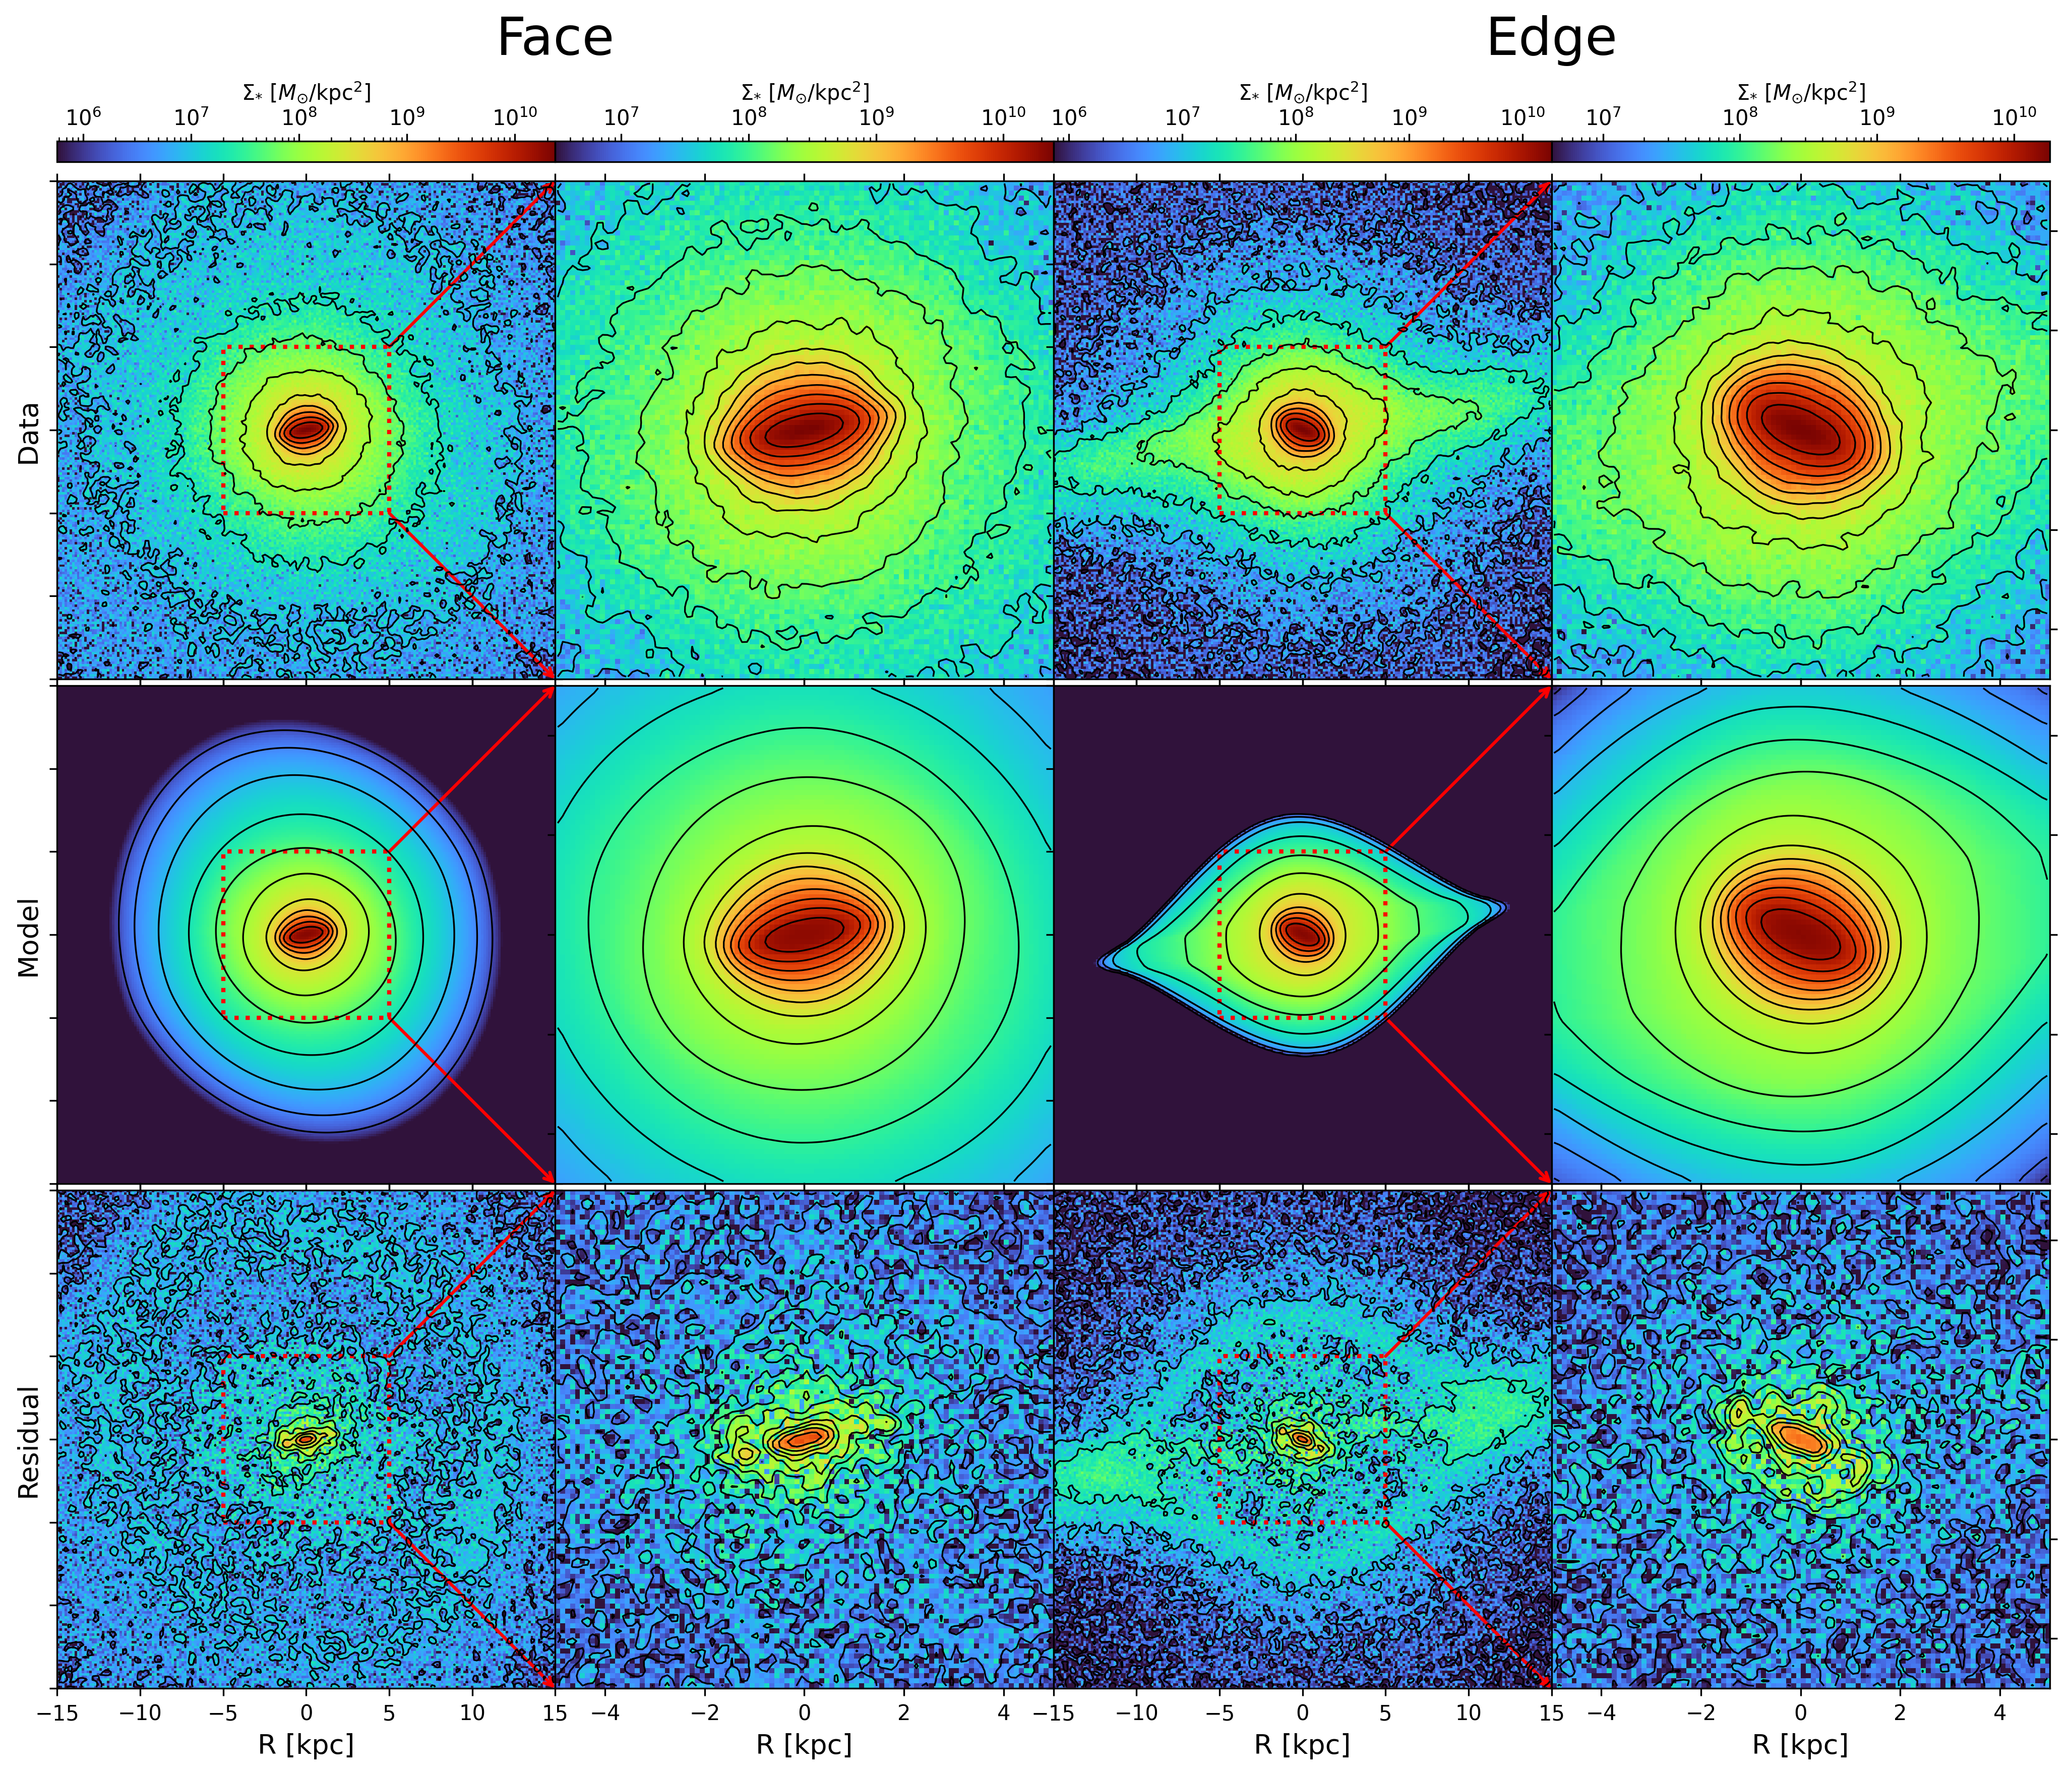

In [16]:
box_lh_max =(np.max(res_ellipsoid_s['a'])//5+1)*5
zoom_lh_max = min(5.,box_lh_max/3)
show_image_model_residual(particle,ellipsoid_s_model,
                          large_box_x_range = (-box_lh_max,box_lh_max),
                          large_box_y_range= (-box_lh_max,box_lh_max),
                          zoom_x_range=(-zoom_lh_max,zoom_lh_max),
                          zoom_y_range=(-zoom_lh_max,zoom_lh_max),
                          depth_z_range=(-box_lh_max,box_lh_max),)